In [1]:
import sys
import stmpy
import numpy as np
import cancelv3 as cancel
from decimal import *
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import pandas as pd
import scipy.fftpack as fftp
import os
from scipy import signal
import scipy
import matplotlib.pyplot as plt
import time
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
%pylab inline

Populating the interactive namespace from numpy and matplotlib


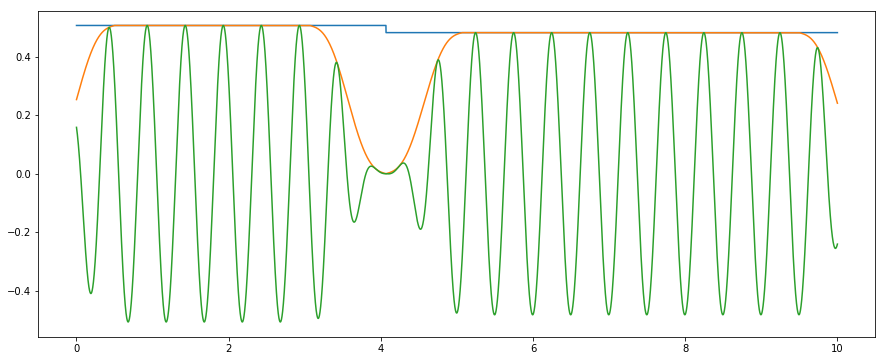

In [2]:
# Functions used in generating synthetic data

#designate randomly selected points of time that have a phase slip 
def slipper(t_array,num, debug = False):
    #num: how many phase slips should be incorporated into the frequency
    #indexInt = random.randint(0,int(len(sz)/rate))
    ti = random.choice(arange(len(t_array)),num)
    return ti

#create Phase Map
def phase_map(t_array, loc,debug = False):
    slipSz = t_array.shape
    loc = np.sort(loc)
    PhaseMap = np.ones(slipSz)*(2*np.pi*random.rand(1)-np.pi)
    for point in loc:
        PhaseMap[point:] = 2*np.pi*random.rand(1)-np.pi
    return PhaseMap

#create Amplitude Map
def amp_map(t_array, slip_loc, freq, amp_i=1, mod=0.1, mod_amp=0.05,debug = False):
    #t_array: the time series values
    #          t_array[1] is used to find the sample rate that was used
    #loc: the index of random time points that a phase shift occurrs
    #freq: frequency that is being modeled. Gaussian width is dependant on freq
    #res_width: resonance width, the bandwidth over which the power of vibration is greater than 
    #               half the power at the resonant frequency
    #gauss_width: width of gaussian curve such that frequency decays to zero at 2 periods
    #amp_i: initial amplitude of function
    #mod: frequency of amplitude madulation
    #mod_amp: amplitude of amplitude modulation
    #debug: for debugging purposes
    
    period = 1/(freq)
    gauss_width = int(2*period*(1/t_array[1]))
    
    res_width = 0.0001
    res_freq = 1
    Q_factor = res_freq/res_width
    
    dropSz = t_array.shape
    slip_loc = np.sort(slip_loc)
    
    variance = 0.1*amp_i
    t1 =time.time()
    AmpMap = np.ones(dropSz)*amp_i + random.normal(0,variance,1)
    t2 = time.time()
    if debug:
        AmpMap2 = np.copy(AmpMap)
    for point in slip_loc:
        change_up = random.normal(0,variance,1)
        if debug:
            AmpMap2[point:] = 1*amp_i + change_up
        AmpMap[point:] = (1*amp_i + change_up)*exp(-(1/Q_factor)*(t_array[point:]-t_array[point]))
        AmpMap[int(point-gauss_width/2):int(point+gauss_width/2)] = 0
    t3 = time.time()
    
    window = signal.hamming(int(gauss_width))
#     method = signal.choose_conv_method(AmpMap, window, mode='same')
    AmpMap = signal.convolve(AmpMap,window, mode='same')/sum(window)
    AmpMap  = AmpMap #+ mod_amp*sin(2*pi*mod*t_array)
    t4 = time.time()
#     print(t2-t1,t3-t2,t4-t3,t4-t1, end='\r')
    if debug:
        return AmpMap,AmpMap2
    return AmpMap

def create_drive(zdata, dt2, tf, freqs):
    fbottom2 = np.fft.fft(zdata)
    freq2 = np.fft.fftfreq(len(zdata),dt2)
    freq2[freq2 > freqs[np.argmax(freqs)]] = freqs[np.argmax(freqs)]
    freq2[freq2 < freqs[np.argmin(freqs)]] = freqs[np.argmin(freqs)]
    
    driver = np.fft.ifft(tf(freq2)*fbottom2)
    return driver

def butterworth_lowpass(sig, cutoff, fs = 10000):
    sos = signal.butter(8, cutoff, 'lowpass', fs=fs, output='sos')
    filtered = signal.sosfilt(sos, sig)
    return filtered

def geophone_response(sig, cutoff, fs = 10000, lor_width = 20):
    b,a = signal.butter(sig,cutoff, 'hp', fs = fs)
    w,h = signal.freqz(b,a)
    plt.semilogx(w, 1000*lorentzian(w,cutoff,lor_width)+ 20 * np.log10(abs(h)))
    filtered = 1000*lorentzian(w,cutoff,lor_width)+ 20 * np.log10(abs(h))

def resonant_filter(sig, w_res, res_width, fs = 10000):
    fft_sig = fft.fft(sig)
    fft_freq = fft.fftfreq(len(sig),1/fs)
    sos = signal.butter(8, 12, 'highpass', fs=fs, output='sos')
    filt_freq, filt_response = signal.sosfreqz(sos,worN=len(fft_sig),fs=fs)
    lor_response = lorentzian(fft_freq,w_res,res_width)
    res_response = 1*lor_response+(20*np.log10(absolute(filt_response)))
#     res_response = 1*lor_response + (np.zeros(shape(filt_response)))
    res_response[int(len(res_response)/2)+1:] = np.flip(res_response[1:int(len(res_response)/2)])
    fft_filt = fft_sig*exp(res_response)
    fft_filt[0] = 0+0j
    
#     plot(fft_freqs,abs(fft_sig))
#     plot(fft_freqs,res_response)
#     xlim(-110,110)
#     ylim(-100,100)
#     plot(fft_freqs,absolute(fft_filt))
    
    print(len(fft.ifft(fft_filt))/fs)
    return fft.ifft(fft_filt)

def butterworth_highpass(sig, cutoff, fs = 10000):
    sos = signal.butter(10, cutoff, 'hp', fs=fs, output='sos')
    filtered = signal.sosfilt(sos, sig)
    return filtered

def view_debug(arg, amp = 1,slips = 2, freq = 10, secs = 10, fs=10000):
    
    t = linspace(0,secs,secs*fs)
    ti = slipper(t,slips)
    phase = phase_map(t, ti)
    amp,amp2 = amp_map(t, ti, freq,amp_i = amp,debug=True)

    freq1 = freq*2*np.pi
    wave = amp*sin(freq1*t + phase)
    fftData = fft.fft(wave)
    freqs = fft.fftfreq(len(fftData),1/fs)
    
    if arg == 'amp':
        plot(t,amp2)
        plot(t,amp)
        plot(t,wave)
#         xlim(t[ti[1]]-4*(2*np.pi/freq),t[ti[1]]+4*(2*np.pi/freq))
        
    if arg == 'phase':
        plot(t,phase)
    
    if arg == 'wave':
        plot(t,wave)

    if arg == 'freq':
        freqs = freqs[:int(len(freqs)/2)]
        fftData = fftData[:int(len(fftData)/2)]
        plot(freqs,absolute(fftData))
        xlim(0,freq*2)
    
def noisy(t_array, amp, fs = 10000, cutoff = 300):
    noise = amp*randn(len(t_array))
    sos = signal.butter(10, cutoff, 'low', fs = fs, output = "sos")
    filtered = signal.sosfilt(sos, noise)
    return filtered

def create_wave(freq_array, amp_array, secs = 10, fs = 10000, slips = 10):
    
#     t1 = time.time()
    t_array = linspace(0,secs,secs*fs)

    
    low_noise = noisy(t_array,0.000005)
    #     Johnson = 0.005*randn(len(t))
    tempWave = np.zeros(len(t_array)) + low_noise
#     print(time.time()-t1)
    for freq,ampi in zip(freq_array,amp_array):
        t2 = time.time()
        ampi = ampi/2000
        ti = slipper(t_array,slips)
        t3 = time.time()
        phase = phase_map(t_array,ti)
        t4 = time.time()
        amp = amp_map(t_array,ti,freq,amp_i = ampi)
        t5 = time.time()
        tempWave += amp*sin(2*np.pi*freq*t_array + phase)
        t6=time.time()
        print(t6-t2, end='\r')
#     fig, (ax_wave,ax_freq) = plt.subplots(2, 1)
#     ax_wave.plot(t_array,tempWave)
#     ax_wave.set_xlim([0, secs])
#     ax_wave.set_title('Synthetic Data')
#     fftData = absolute(fft.fft(tempWave)/secs)
#     freq = fft.fftfreq(len(fftData),1/fs)
#     ax_freq.loglog(freq[:int(len(freq)/2)],fftData[:int(len(fftData)/2)])
#     ax_freq.set_xlim(0,400)#max(freq_array))
# #     ax_freq.set_ylim(0,1)
#     ax_freq.set_title('Synthetic Data')
    
    return tempWave, t_array




# Subtract mean and divide by range.
def normalize2(array):
    return (array-mean(array))/(max(array) - min(array))

def lorentzian(w, w0, g):
    return (1/pi) * (g/2) / ( (w-w0)**2 + (g/2)**2 )


figsize(15,6)
view_debug('amp',amp= 0.5,slips = 1,freq = 2,secs = 10)


## Environmental Vibration Data

In [3]:
figsize(15,6)
#frequencies and magnitudes found upon inspection of data from 2019-02-25
freqs = [1.6, 2, 2.5, 30, 33, 34, 36, 50, 57, 60, 100, 101, 111,
         118, 125, 263, 264, 265, 266, 267, 270]
#          300, 360, 420, 480, 540, 600, 660, 720, 780, 840, 900]
#          10, 20, 30, 31.8, 40, 46, 48, 50, 57, 60, 70, 90, 100, 110, 120, 
#          146, 150, 180, 200, 210, 220, 240, 250, 300, 360, 411, 420,
#          480, 540, 660, 780, 840, 900, 1020]
electric_freq = [60,120,180,240,300,360,420,480,540,600,660,720,780,840,900]
electric_amp =  [ 0.04,0.065, 0.3,0.06,0.15, 0.05, 0.25, 0.02, 0.08, 0.05, 0.45, 0.4, 0.45, 0.3, 0.06]
amps = [0.6, 0.3, 0.2, 0.125, 0.01, 0.05, 0.075, 0.01, 0.08, 0.04, 0.035, 0.04, 0.06,
        0.07, 0.01, 0.02, 0.03, 0.04, 0.02, 0.03, 0.02] 
#         0.15, 0.05, 0.25, 0.02, 0.08, 0.05, 0.45, 0.4, 0.45, 0.3, 0.06]
#          0.5, 0.4, 0.05, 0.1, 0.05, 0.05,0.05, 0.05, 0.05, 0.01, 0.003, 0.003, 0.1, 0.02, 0.08,
#          0.01, 0.02, 0.25, 0.005, 0.005, 0.01, 0.06, 0.006, 0.001, 0.04, 0.002, 0.005,
#          0.001, 0.003, 0.002, 0.001, 0.0005, 0.001, 0.001]

start = time.time()
wave,t = create_wave(freqs, amps,secs = 100,slips = 100)
for freq,amp in zip(electric_freq,electric_amp):
    wave = wave + (amp/2000)*sin(freq*2*np.pi*t + (2*np.pi*random.rand(1)-np.pi))
print(time.time()-start,end= '\r')
# secs | slips | time per frequency | total time
# 100     1           0.1 s              4.1 s
# 100     10          0.2 s              6.1 s
# 100     100         0.9 s             32.07 s
# 1000    1           1.0 s             36.54 s
# 1000    10          2.0 s             61.61 s
# 1000    100         9.1 s            336.85 s
# 1200    100        11.5 s            390.46 s
# 1000    1000      116.5 s              ...

## Geophone Data

C:\Users\jgoet\Anaconda3\lib\site-packages\ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in log10


100.0


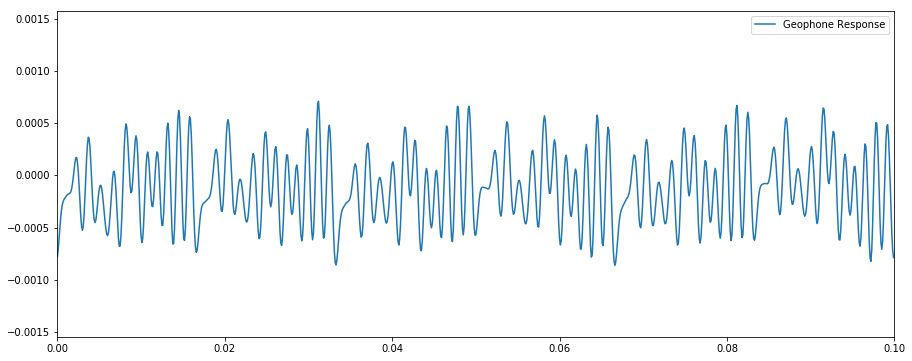

In [38]:
#put data through a high pass filter
# 
noise_freq = [0.1, 0.5, 1.8, 2.6, 3.1,5.7,6.1,16]
noise_amp = [0.25,0.2,0.5,0.425,0.15,0.05,0.1]
geo = resonant_filter(wave,30,6)
geo1,t = create_wave(noise_freq, noise_amp,secs = 100,slips = 10) 
geo = geo+geo1
fft_geo = fft.fft(geo)
freq_geo = fft.fftfreq(len(geo),1/10000)
# plot(t,wave,label='Environmental Vibrations')
plot(t,geo,label='Geophone Response')
xlim(0,0.1)
legend()

(0, 400)

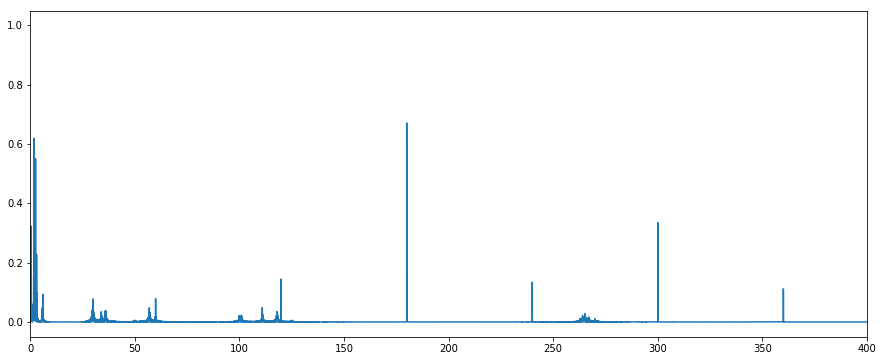

In [5]:
plot(freq_geo[:int(len(freq_geo)/2)],normalize2(absolute(fft_geo[:int(len(freq_geo)/2)])))
xlim(0,400)

# Tip Data

## Idealized Transfer Function

60
[2.         2.00006803 2.00013605 2.00020408 2.00027212]
[59.9918376  59.9938781  59.99591866 59.9979593 ]


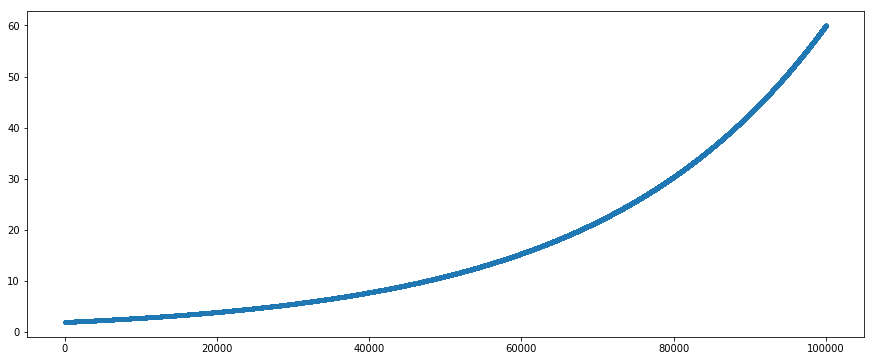

In [6]:
w2 = np.logspace(log10(freqs[1]),log10(freqs[int(-1+len(freqs)/2)]),100000)
print(freqs[-1+int(len(freqs)/2)])
print(w2[0:5])
print(w2[-5:-1])
plot(w2,'.')

(-1.565274522973431e-08-1.021724049728969e-08j) (-7.752020439013218e-09-5.065314479861125e-09j) (-7.75202e-09-5.0653144e-09j)


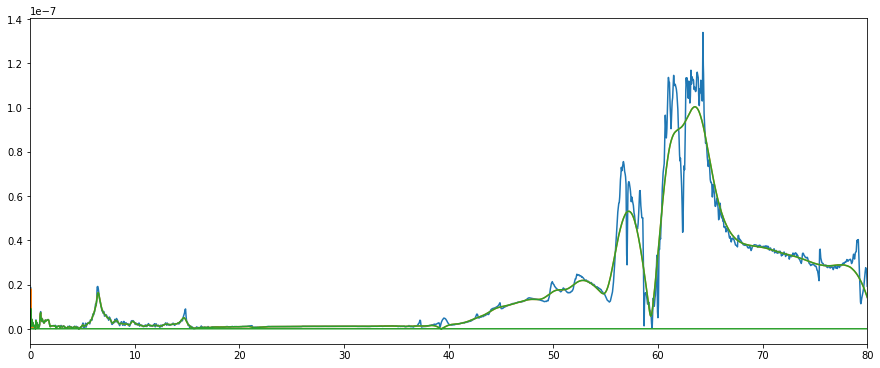

In [7]:
[transf_Alb, freqs_Alb] = joblib.load('Albert_Data/2019-02-26/trx2_v2')

transf = transf_Alb
freqs = freqs_Alb

w2 = logspace(log10(freqs[1]),log10(freqs[-1+int(len(freqs)/2)]),100000)
#transf is already an interpolation of frequencies
T = transf(w2)

T_flt = butterworth_lowpass(absolute(T),100,fs=10000)

window = signal.hamming(int(500))
T_flt2 = signal.convolve(T,window, mode='same')/sum(window)

# plot(freqs,absolute(transf(freqs)))
plot(w2,absolute(T))
# plot(w2,absolute(T_flt))
plot(w2,absolute(T_flt2))


f = scipy.interpolate.interp1d(w2,T_flt2, kind='linear')

freq_lin = linspace(w2[0],w2[-1],99999)
# print(w2[0],freq_lin[0],w2[-1],freq_lin[-1])
# print(w2[1],freq_lin[1],w2[-2],freq_lin[-2])
transf_flt = np.zeros(shape(freqs),dtype=np.complex64)
transf_flt[1:100000] = f(freq_lin)
transf_flt[100000:] = np.flip(transf_flt[:100000])

print(T[0],T_flt2[0],transf_flt[1])
plot(freqs,absolute(transf_flt))
xlim(0,80)
new_transf = scipy.interpolate.interp1d(freqs,transf_flt, kind='linear')
# T_flt = butterworth_lowpass(absolute(T),5000,fs = 10000)
# loglog(w2,T_flt,'.')
# xlim(0,5000)
# xlim(0,10)

# w3 = linspace(0,len(freqs)/10000,20000000)
# f2 = scipy.interpolate.interp1d(w2,T_flt)
# T_lin = f2(w3)

In [8]:
# folder_loc = 'Albert_Data/2019-02-21/'
# file_loc = 'fast-transfer-function-'

# dat_cal = np.loadtxt(folder_loc+file_loc+'001'+'.dat',skiprows=119)
# count = 1
# for j in arange(2,100):
#     file = folder_loc+file_loc+str(j).zfill(3)+'.dat'
#     try:
#         temp_dat = np.loadtxt(file,skiprows=119)
#         dat_cal = np.concatenate((dat_cal,temp_dat))
#         print(j,end='\r')
#     except:
#         pass

In [9]:
# plot(normalize2(dat_cal[:,0]))
# plot(normalize2(dat_cal[:,1]))

In [10]:
# plot(fft.fftfreq(len(dat_cal[:,0]),1/10000),normalize2(abs(fft.fft(dat_cal[:,0]))))
# plot(fft.fftfreq(len(dat_cal[:,0]),1/10000),normalize2(abs(fft.fft(dat_cal[:,1]))))
# xlim(50,62.5)
# ylim(0,0.006)

## Tip Data Calculation

(1000000,)823181152


(0, 400)

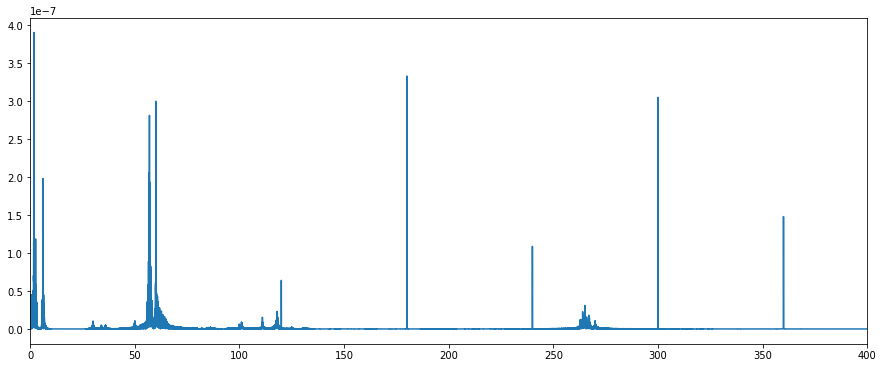

In [11]:
#create data from real transfer function 
#add some additional noise
tip_noise_freq = [0.1, 0.5, 1.8, 2.6, 3.1,5.7,6.1,16]
tip_noise_amp = [0.5,0.4,1,0.85,0.3,0.1,0.2]
temp_geo = np.copy(geo)
noise_wave,t = create_wave(tip_noise_freq,tip_noise_amp,secs=100,slips=20)
# for freq,amp in zip(tip_noise_freq,tip_noise_amp):
#     temp_geo = temp_geo + (amp/5e3)*sin(freq*2*np.pi*t + (2*np.pi*random.rand(1)-np.pi))
temp_geo = temp_geo + noise_wave
print(shape(temp_geo))
tip = create_drive(temp_geo,1/10000,new_transf,freqs)
fft_tip = fft.fft(tip)
freqs_tip = fft.fftfreq(len(fft_tip),1/10000)
plot(freqs_tip[:int(len(freqs_tip)/2)],absolute(fft_tip[:int(len(freqs_tip)/2)]))
xlim(0,400)

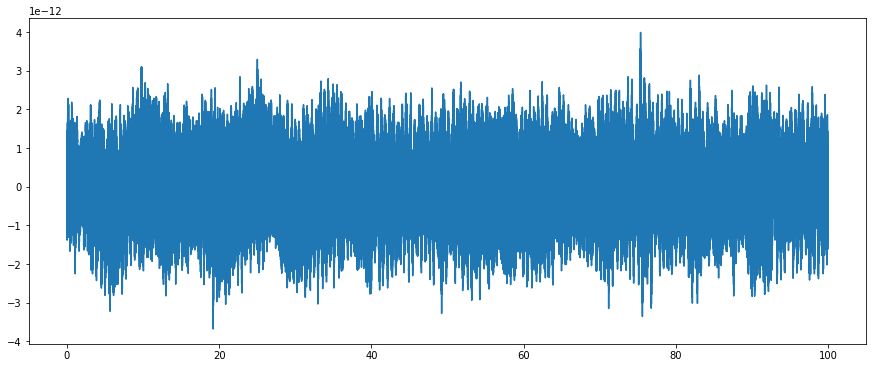

In [12]:
plot(t,tip)

## Transfer Function Creation

In [13]:
#Function finds the reshape value of the data to get closest to the desired frequency resolution
def res(freq_res, data_length, fs = 10000):
    # freq_res: desired frequency resolution
    # data_length: length of the data being transformed
    # fs: sampling rate that data was collected at (default=10000)
    #  Output:
    # Cuts: value that data can be reshaped as to reach desired resolution  
    cuts = int((data_length*freq_res)/fs)
    data_end = data_length%cuts
    return cuts,data_end

calibration_length = int(0.9*len(geo))
resolution = 0.1
cuts,end = res(resolution,calibration_length)

geo_cal, geo_test = geo[:calibration_length-end],geo[calibration_length:]
tip_cal, tip_test = tip[:calibration_length-end],tip[calibration_length:]

print(len(geo_cal))
nc = cancel.Cancel(geo_cal,tip_cal,1/10000,p=[100000,50000,5])
transf = nc.transf
freqs = nc.freqs

900000


(0, 400)

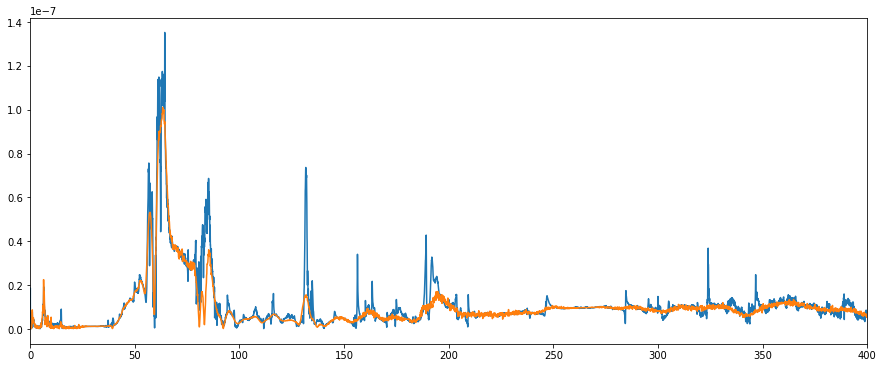

In [14]:
plot(freqs_Alb[:int(len(freqs_Alb)/2)],absolute(transf_Alb(freqs_Alb[:int(len(freqs_Alb)/2)])))
plot(freqs[:int(len(freqs)/2)],absolute(transf(freqs[:int(len(freqs)/2)])))
xlim(0,400)

## Z Cancellation

(0, 1)

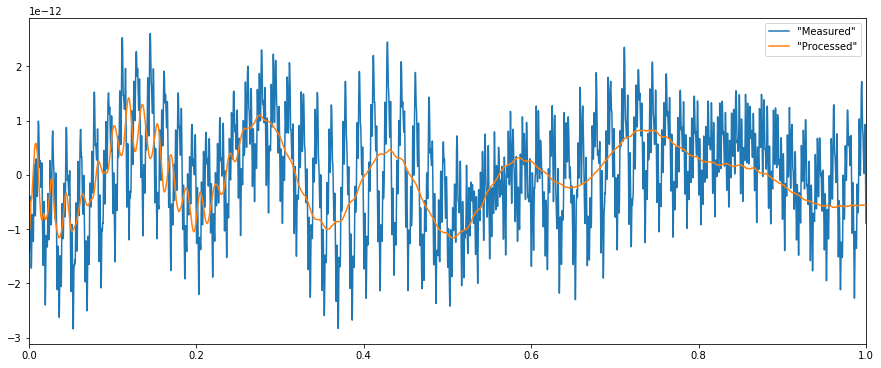

In [36]:
t= linspace(0,len(tip)/10000,len(tip))
z_noise = create_drive(geo_test,1/10000,transf,freqs)

plot(t[:len(tip_test)],tip_test,label='"Measured"')
# plot(t[:len(tip_test)],z_noise)
plot(t[:len(tip_test)],tip_test-z_noise,label='"Processed"')
legend()
xlim(0,1)

## Current Data

-16313539785.538061
(-1.2215413188095184e-12-3.99836585113227e-12j)


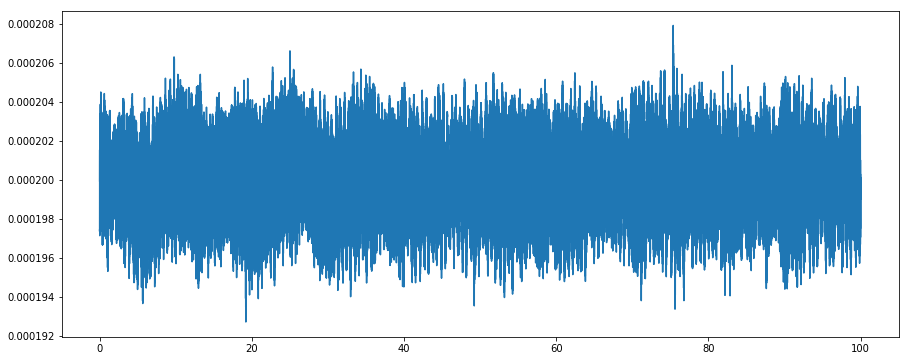

In [35]:
foldername='Albert_Data/2019-02-25/'
z_spec=loadtxt(foldername+'Z-Spectroscopy-noisy001.dat',skiprows=62)
fit = polyfit(z_spec[:,0],log(abs(z_spec[:,1])),1)
kappa = -10000000000#fit[0]
print(fit[0])
I_0 = 200e-6
cur = I_0*exp(-kappa*tip)
print(tip[0])
plot(t,cur)
# xlim(0,1)

## Current Data with Modulation

(0, 0.1)

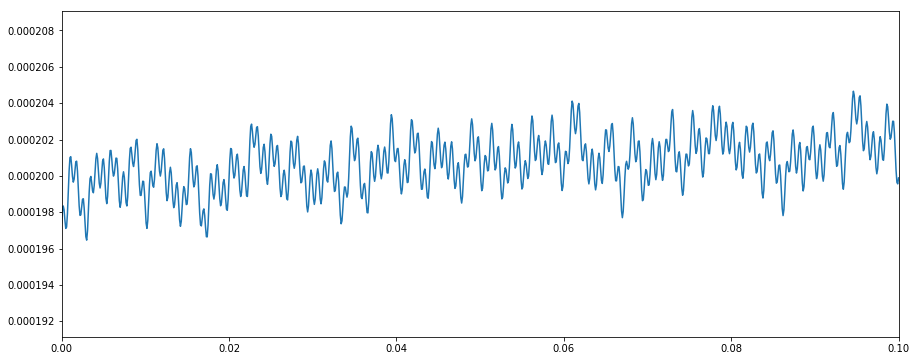

In [31]:
v_dc = np.zeros(len(cur))
v_mod = 1250
mod_amp = 1e-6
# mod_amp = 1
VMap = v_dc + mod_amp*sin(2*np.pi*v_mod*t)
cur_mod = cur+VMap
# plot(t,cur_mod)
plot(t,cur_mod)
xlim(0,0.1)

## LIX Data

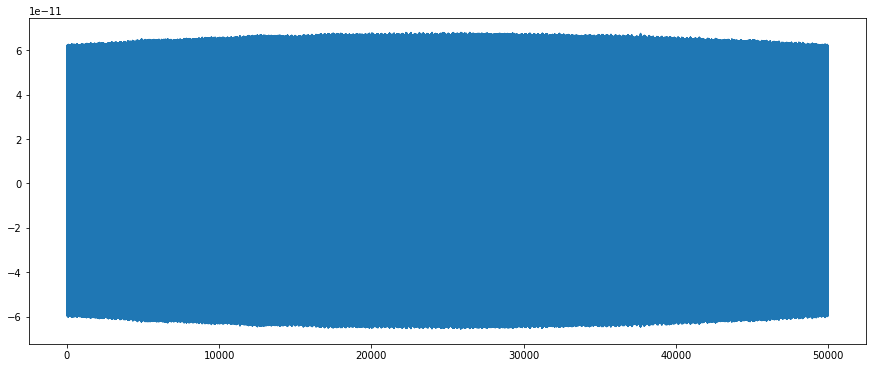

In [34]:
coefficient = v_mod/10000
v_ac = VMap - mean(VMap)
a = 0
# print(coefficient,shape(cur_mod),shape(v_ac),shape((cur_mod*v_ac)))
lix_calc = (coefficient*sum((cur_mod*v_ac).reshape(-1,20), axis=1))
# plot(v_ac[::40])
plot(lix_calc)
# xlim(0,100)
# print(len(lix_calc))

## Exact Propogation

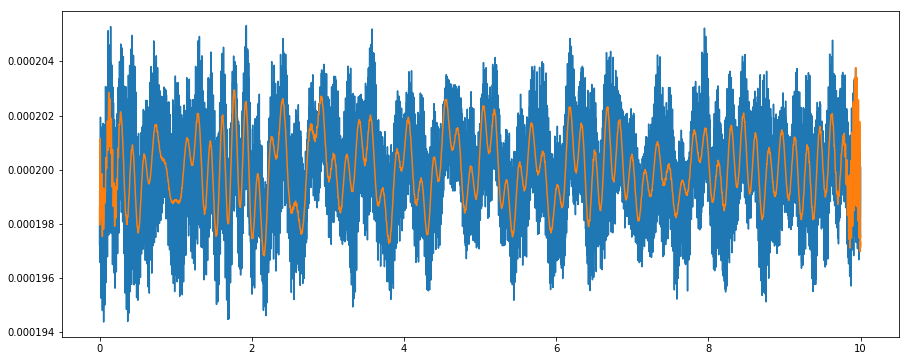

In [19]:
cur_noise = exp(-(z_noise-mean(z_noise))*kappa)
cur_cal, cur_test = cur[:calibration_length-end],cur[calibration_length:]

figsize(15,6)
t = linspace(0,len(cur_test)/10000,len(cur_test))
cur_correct = cur_test/(cur_noise)

plot(t,cur_test)
plot(t,cur_correct)
# xlim(0,40)

## Z-LIX

In [20]:
# A function that returns array with the n-th degree polynomial background removed. 
def fit_cancel(array, n=1):
    t=linspace(0,len(array),len(array))
    fit = polyfit(t,array,n)
    corrective = fit[n]*ones(shape(t))
    for j in arange(n):
        corrective += fit[j]*(t**(n-j))
    return array - corrective
lix_cal, lix_test = lix_calc[:calibration_length-end],lix_calc[calibration_length:]


lix_transf = cancel.Cancel(geo_cal-mean(geo_cal),fit_cancel(lix_cal-mean(lix_cal)),1/10000,p=[100000,50000,5])
lix_noise = lix_transf.create_drive(geo_test-mean(geo_test))

plot(lix_test*1e12)
plot(lix_test*1e12-lix_noise*1e12)

ValueError: negative dimensions are not allowed

# Attempt to add resonance peak to geophone sensitivity 

In [ ]:
t = linspace(0,10,100000)
sig1 = sin(30*2*np.pi*t)
sig = sig1#+1*sin(100*2*np.pi*t)

b,a = signal.butter(8,60,'lowpass',fs = 10000, output = 'ba')
b1,a1 = signal.iirpeak(30,100,10000)

filter1 = signal.lfilter(b,a,sig)
filter2 = signal.lfilter(b1,a1,sig)
con_sig = signal.convolve(filter1,filter2,mode='same')
plot(t,sig)
plot(t,filter1,label='highpass')
plot(t,filter2,label='peak')
# plot(t,con_sig,label='convolved')
# xlim(0.5,0.75)
legend()
# print(b,b1)
# b_con = signal.convolve(b,b1)
# a_con = signal.convolve(a,a1)

# freq,h = signal.freqz(b,a,fs=10000)
# freq1,h1 = signal.freqz(b1,a1,fs=10000)
# freq2,h2 = signal.freqz(b_con,a_con,fs=10000)
# semilogx(freq, 20*np.log10(abs(h)),label='standard')
# semilogx(freq1, 20*np.log10(abs(h1)),label='peak')
# semilogx(freq, 20*np.log10(abs(h+h1)),label='freq response')
# semilogx(freq2, 20*np.log10(abs(h2)),label='convolution')
# xlim(10,1000)
# ylim(-60,10)
# legend()

In [ ]:

b,a = signal.butter(8,60,'lowpass',fs = 10000, output = 'ba')
b1,a1 = signal.iirpeak(30,100,10000)



In [ ]:
b, a = signal.butter(8, 0.2)
step_response = signal.lfilter(b, a, np.ones(5000))
plot(step_response)
xlim(0,100)

In [ ]:
import scipy
x = linspace(1, 10,100)
y = np.exp(-x/3.0)
f = scipy.interpolate.interp1d(x, y)
xnew = logspace(0, 1, 100)
ynew = f(xnew)   # use interpolation function returned by `interp1d`
plt.plot(x, y, 'o')
plot(xnew, ynew, '.')
xlim(0,10)
plt.show()

In [ ]:
t= linspace(0,1,100)
x = t.shape
ti = slipper(t,2)
print(shape(ti))

In [ ]:
h2 = 100*lorentzian(w,30,10)
loglog(w,h2)
# xlim(250,350)

# Meeting with Jenny
### Who am I?
### See if transfer function is the same at different biases
### 
##### Scan tube resonant frequency ~3kHz
#####             STM 2 ~2kHz
#####             STM 3 ~1.5kHz
##### Driven data G(t) and Z(t) peaks noisy_cur
###### Lab View-  see pic
###### Topographic Cancellation w/ Neural Network

In [ ]:
x = linspace(1,300,299)
x1 = logspace(log10(1),log10(299),299)
print(x[0],x1[0],x[298],x1[298])
sig = np.zeros(299)
sig[100:200] = 1
sig[0:50] = 1
# print(shape(sig))
f1 = scipy.interpolate.interp1d(x,sig, kind='linear')
sig1 = f1(x1)
win = signal.hann(50)
filtered = signal.convolve(sig1, win, mode='same') / sum(win)
x2 = linspace(1,298,150)
# print(shape(x))
f = scipy.interpolate.interp1d(x1,filtered, kind='linear')
y = f(x2)
# plot(x,sig)
# plot(x1,sig1)
plot(x1,filtered)
plot(x2,y)